### 1 - Dataset Presentation:
The chosen dataset is the UCI Heart Disease dataset, available at this page: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data

This dataset aims to identify whether a patient has heart disease, based on several metrics such as age, cholesterol level, or type of chest pain.

The problem to solve is quite clear, since being able to detect increased chances of heart disease would facilitate screening, and avoid the need for every patient to undergo tests, which is impossible, or for a doctor to arbitrarily decide if further analysis is necessary or not. With a good model, we could therefore have fewer undetected cases, or fewer cases unnecessarily analyzed in depth.

We will focus on trying to predict whether a patient has heart disease, as this is enough to consider further screenings, and we will explore classifying it to the severity. For this, we will use the following features:

- age
- sex
- cp - chest pain type, in these values: [typical angina, atypical angina, non-anginal, asymptomatic]
- trestbps - blood pressure when resting
- chol - cholesterol levels
- fbs - whether the fasting blood sugar is above 120 mg/dl (which is too high and unhealthy)
- restecg - electrocardiographic results at rest, in these values: [normal, stt abnormality, lv hypertrophy]
- thalach - max heart rate
- exang - whether patient has an angina induced by exercise
- oldpeak - ST depression when doing exercise compared to while resting (ST depression is a dip in the electrocardiogram)
- slope - description of the slope at the peak of the electrocardiogram while doing exercise
- ca - number of major vessels colored by fluoroscopy, between 0 and 3
- thal - If the patient has thalassemia, in these values:  [normal, fixed defect, reversible defect] (thalassemia is a genetic condition)

### 2 - Dataset analysis

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

dataset = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "redwankarimsony/heart-disease-data",
  "heart_disease_uci.csv",
)

print("First 5 records:", dataset.head())

/home/luanico/.pyenv/versions/3.9.22/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_25274/2236226578.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  dataset = kagglehub.load_dataset(


First 5 records:    id  age     sex    dataset  ...        slope   ca               thal num
0   1   63    Male  Cleveland  ...  downsloping  0.0       fixed defect   0
1   2   67    Male  Cleveland  ...         flat  3.0             normal   2
2   3   67    Male  Cleveland  ...         flat  2.0  reversable defect   1
3   4   37    Male  Cleveland  ...  downsloping  0.0             normal   0
4   5   41  Female  Cleveland  ...    upsloping  0.0             normal   0

[5 rows x 16 columns]


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
dataset.describe(include='all')

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
count,920.000000,920.000000,920,920,920,861.000000,890.000000,830,918,865.000000,865,858.000000,611,309.000000,434,920.000000
unique,NaN,NaN,2,4,4,NaN,NaN,2,3,NaN,2,NaN,3,NaN,3,NaN
top,NaN,NaN,Male,Cleveland,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,flat,NaN,normal,NaN
freq,NaN,NaN,726,304,496,NaN,NaN,692,551,NaN,528,NaN,345,NaN,196,NaN
mean,460.500000,53.510870,NaN,NaN,NaN,132.132404,199.130337,NaN,NaN,137.545665,NaN,0.878788,NaN,0.676375,NaN,0.995652
std,265.725422,9.424685,NaN,NaN,NaN,19.066070,110.780810,NaN,NaN,25.926276,NaN,1.091226,NaN,0.935653,NaN,1.142693
min,1.000000,28.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,-2.600000,NaN,0.000000,NaN,0.000000
25%,230.750000,47.000000,NaN,NaN,NaN,120.000000,175.000000,NaN,NaN,120.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
50%,460.500000,54.000000,NaN,NaN,NaN,130.000000,223.000000,NaN,NaN,140.000000,NaN,0.500000,NaN,0.000000,NaN,1.000000
75%,690.250000,60.000000,NaN,NaN,NaN,140.000000,268.000000,NaN,NaN,157.000000,NaN,1.500000,NaN,1.000000,NaN,2.000000


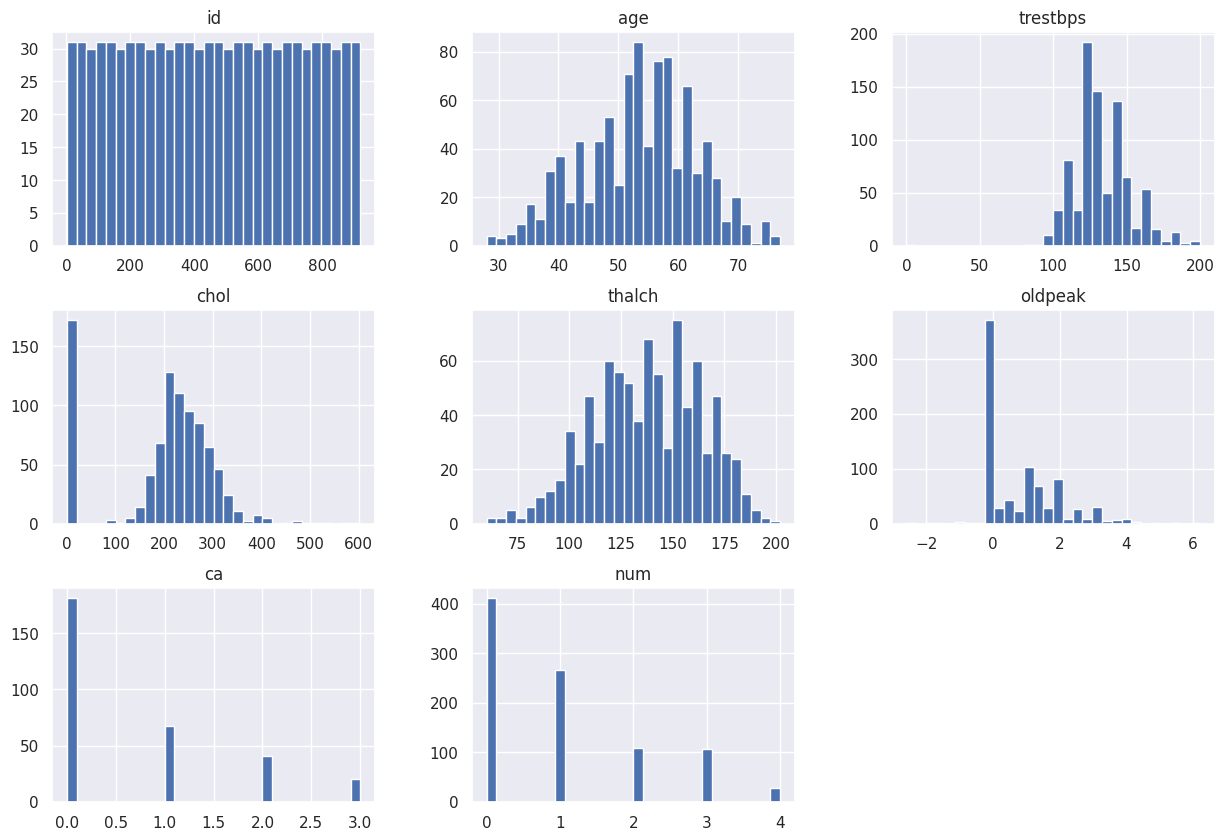

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

dataset.hist(bins=30, figsize=(15, 10))
plt.show()

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

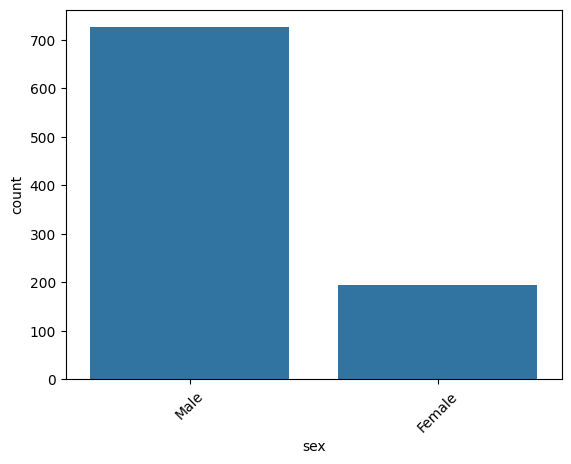

In [6]:
sns.countplot(x='sex', data=dataset)
plt.xticks(rotation=45)

<Axes: >

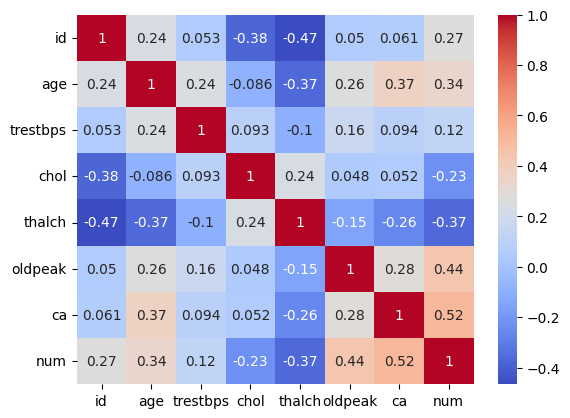

In [7]:
corr = dataset.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')

### 3 - Classification

First, we have to preprocess the data. As seen before, most parameters are not always present. We chose to fill those with the median for numerical parameters, and with unknown for categorical parameters. This is arbitrary, we could have also dropped some parameters for example, or discard rows with missing info, but as the dataset is already not very large (< 1000), we decided not to go with this approach. Replacing missing values also means that a new patient, with some missing analysis, could still get a prediction.


We also scale the data before for better results. 

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# We drop id and dataset which are irrelevant
df = dataset.drop(columns=["id", "dataset"])

# For numerical values, we fill NaN with the median
for col in ['trestbps', 'chol', 'thalch', 'oldpeak']:
    df[col] = df[col].fillna(df[col].median())

# For categorical values, we fill with Unknown category. We consider ca as a categorical value since it can take only 4 fixed values.
# We then encode them
for col in ["fbs", "restecg", "exang", "slope", "thal", "sex", "cp", "ca"]:
    encoder = LabelEncoder()
    df[col] = df[col].fillna("Unknown")
    df[col] = df[col].apply(lambda x: str(x))
    df[col] = encoder.fit_transform(df[col])

# To see correlation of parameters to the target
corrs = df.corr()["num"].sort_values(ascending=False)
print(corrs)

# We simplify the problem
df["num"] = df["num"].apply(lambda y: 0 if y == 0 else 1)


X = df.drop(columns="num")
Y = df["num"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

num         1.000000
oldpeak     0.411588
age         0.339596
exang       0.338166
sex         0.259342
fbs         0.186664
thal        0.147872
ca          0.132711
trestbps    0.113178
slope       0.087990
restecg     0.034211
chol       -0.230539
cp         -0.314518
thalch     -0.349173
Name: num, dtype: float64


Now let's try classifying this data. For this, we will use different methods:
- Linear regression
- SVC
- K neighbors
- Multi-layered Perceptron
- AdaBoost classifier

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, stratify=Y
)

lgr = LogisticRegression()
svc = SVC()
kneighbors = KNeighborsClassifier()
mlp = MLPClassifier(early_stopping=True)
ada = AdaBoostClassifier()


models = {
    "Logistic Regression": (
        lgr,
        {"C":[0.01, 0.1, 1, 10]}
    ),
    "SVC":(
        svc,
        {
            "C": [0.1, 1, 10],
            "kernel": ["rbf", "linear"],
            "gamma": ["scale", "auto"]
        }
    ),
    "K neighbors":(
        kneighbors,
        {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    ),
    "MLP": (
        mlp,
        {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001],
        }
    ),
    "Ada": (
        ada,
        {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.5, 1.0, 1.5]
        }
    )
}

cv = StratifiedKFold(shuffle=True)

results = {}
bestModels = {}
for name, (model, params) in models.items():
    start = time.time()
    search = GridSearchCV(model, params, cv=cv)
    search.fit(X_train, y_train)
    best = search.best_estimator_
    predicted = best.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    cm = confusion_matrix(y_test, predicted)
    elapsed = time.time() - start
    results[name] = (acc, cm, elapsed)
    bestModels[name] = best
    print(f"Doing {name}:")
    print(f"    Best parameters: {search.best_params_}")
    print(f"    Accuracy: {acc}. Time taken: {elapsed}")
    print(f"    Time taken: {elapsed}")

Doing Logistic Regression:
    Best parameters: {'C': 0.01}
    Accuracy: 0.7663043478260869. Time taken: 0.04877805709838867
    Time taken: 0.04877805709838867
Doing SVC:
    Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    Accuracy: 0.7608695652173914. Time taken: 0.6339108943939209
    Time taken: 0.6339108943939209
Doing K neighbors:
    Best parameters: {'n_neighbors': 7, 'weights': 'distance'}
    Accuracy: 0.7989130434782609. Time taken: 0.15565800666809082
    Time taken: 0.15565800666809082
Doing MLP:
    Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
    Accuracy: 0.7554347826086957. Time taken: 1.6588854789733887
    Time taken: 1.6588854789733887
Doing Ada:
    Best parameters: {'learning_rate': 1.0, 'n_estimators': 50}
    Accuracy: 0.782608695652174. Time taken: 5.2440831661224365
    Time taken: 5.2440831661224365


Let's plot the confusion matrices of each method:

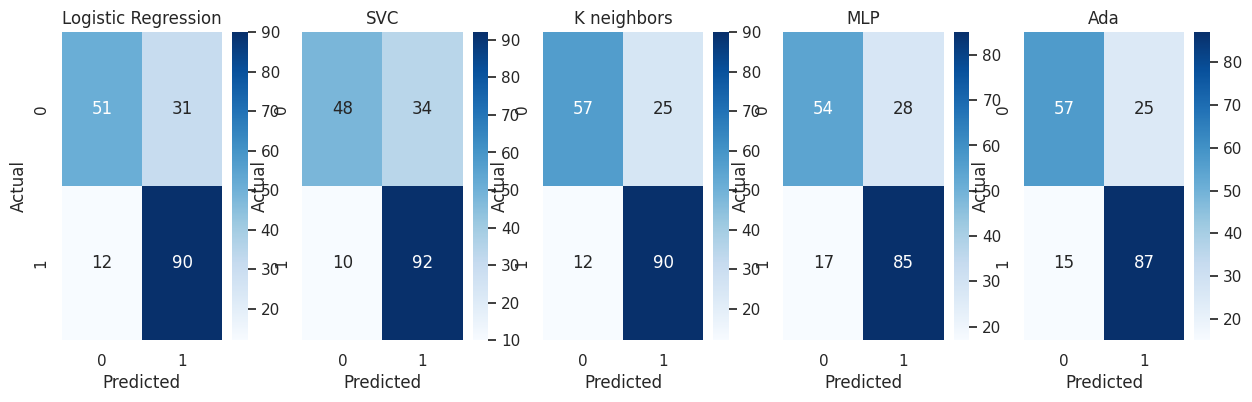

In [148]:
fig, axes = plt.subplots(1, len(models), figsize=(15, 4))


for ax, (title, (_, cm, _)) in zip(axes, results.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.show()

As we can see, the results are pretty similar no matter the method. It sometimes randomly has a better accuracy for one of the methods, but this isn't consistent at all. Based on this, we would rather choose Linear Regression. This approach has the advantage of being more transparent, as we can trace why a certain patient is classified in a category. This is especially important in the health domain, as explainability is necessary to avoid doing medical mistakes.